In [ ]:
#Installing all the required packages


In [ ]:
pip install tsmoothie


In [ ]:
from scipy.optimize import minimize
import scipy
import numpy as np
from scipy.linalg import expm
from numpy.linalg import multi_dot
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.signal import dstep
import cvxpy as cp

In [ ]:
# Linearizing the system
# Defining systame parameters
a1 = 2.3 # cm^2
a2 = 2.3 # cm^2
a3 = 2.3 # cm^2
a4 = 2.3 # cm^2
A1 = 730 # cm^2
A2 = 730 # cm^2
A3 = 730 # cm^2
A4 = 730 # cm^2
h1_0 = 14.1839 # cm
h2_0 = 11.25046 # cm
h3_0 = 21.0841 # cm
h4_0 = 31.0452 # cm
k1 = 2.51 # cm^3/s
k2 = 5.58 # cm^3/s
g = 981 # cm/s^2

#PHASE PARAMETERS
gamma1 = 0.5
gamma2 = 0.45

v1 = 120
v2 = 25
qa = v1*k1 # cm^3/s
qb = v2*k2 # cm^3/s

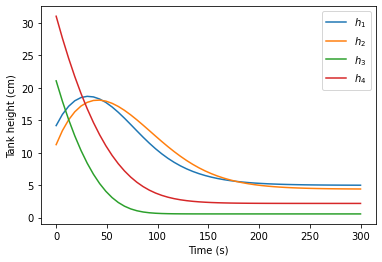

4.992445500913134 4.41023238496649 0.5671776642135398 2.1853571032995855


In [ ]:
def f(t, hj):
  h1,h2,h3,h4 = hj
  dh1dt = -a1 / A1 * (2 * g * h1) ** 0.5 + a3 / A1 * (2 * g * h3) ** 0.5 + gamma1 * qa / A1
  dh2dt = -a2 / A2 * (2 * g * h2) ** 0.5 + a4 / A2 * (2 * g * h4) ** 0.5 + gamma2 * qb / A2
  dh3dt = -a3 / A3 * (2 * g * h3) ** 0.5 + (1 - gamma2) * qb / A3
  dh4dt = -a4 / A4 * (2 * g * h4) ** 0.5 + (1 - gamma1) * qa / A4
  return [dh1dt,dh2dt,dh3dt,dh4dt]

hj0 = np.array([h1_0,h2_0,h3_0,h4_0]) 
sol = solve_ivp(fun=f, t_span=(0, 300), y0=hj0, max_step=0.1, t_eval=np.linspace(0,300))

plt.plot(sol.t, sol.y[0], label='$h_{1}$')
plt.plot(sol.t, sol.y[1], label='$h_{2}$')
plt.plot(sol.t, sol.y[2], label='$h_{3}$')
plt.plot(sol.t, sol.y[3], label='$h_{4}$')
plt.xlabel('Time (s)')
plt.ylabel('Tank height (cm)')
plt.legend()
plt.show();
print(sol.y[0][-1],sol.y[1][-1],sol.y[2][-1],sol.y[3][-1])

In [ ]:
T1 = A1 / a1 * np.sqrt(2 * h1_0 / g)
T2 = A2 / a2 * np.sqrt(2 * h2_0 / g)
T3 = A3 / a3 * np.sqrt(2 * h3_0 / g)
T4 = A4 / a4 * np.sqrt(2 * h4_0 / g)


A = np.array([[-1 / T1, 0, A3 / (A1 * T3), 0],
              [0, -1 / T2, 0,A4 / (A2 * T4)],
              [0, 0, -1 / T3, 0],
              [0, 0, 0, -1 / T4]])
B = np.array([[gamma1 / A1, 0],[0, gamma2 / A3],[0, (1-gamma2) / A3],[(1-gamma1) / A4, 0]])
C = np.array([[1, 0, 0, 0],[0, 1, 0, 0]])
D = np.array([[0, 0],[0, 0]])

In [ ]:
# Model Predictive Control
P = 6 # prediction horizon
M = 5
w1 = 0.1 # weight
w2 = 0.7 # weight
W1 = w1 * np.eye(2*M) # weight matrix for 1 input
W2 = w2 * np.eye(2*M) # weight matrix for 1 input

r1 = np.ones((P,1)) * 18 # single output set point
r2 = np.ones((P,1)) * 15 # single output set point

N =5000 # model length, duration of time
delta_t = 0.1 # sample time
tf_step = N * delta_t #final simulation time for step response generation in s
t_step = np.linspace(0, tf_step, N+1)

t_f = 5000 # total simulation time in s, not necessarily step response generation
t = np.linspace (0, t_f, round(t_f/delta_t)+1)

Text(0, 0.5, 'Output y2 response to step in u$_2$')

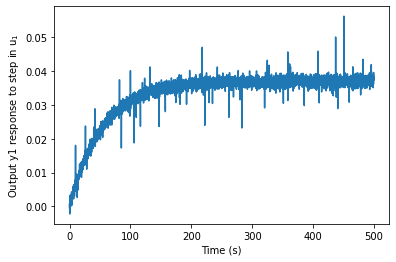

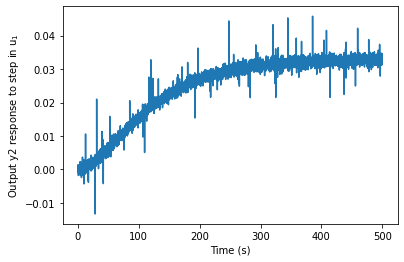

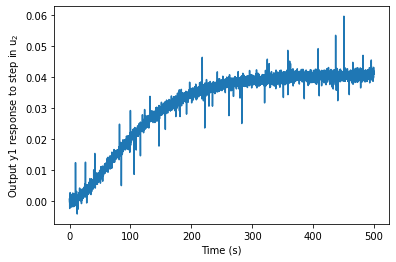

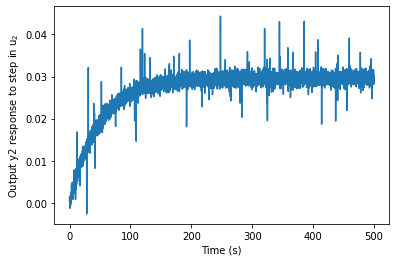

In [ ]:
# Actual step responses
# Plant model(i) or step response

# Generate step response coefficient(ii)
Phi = expm(np.multiply(A,delta_t))
Gamma = multi_dot([Phi-np.eye(4),np.linalg.inv(A),B])



#Adding Gaussian noise to make sure that the step response coefficients are robust
sigma = 0.006
g = 0.02
np.random.seed(6)
n=len(t_step)

v = np.zeros((4,n+1))
v[:,0] = [0,0,0,0]
#2 output vectors for each input
y1noise = np.zeros((2,n))
y2noise = np.zeros((2,n))

#generate random input and noise vectors
#Input vector definitions
u1=np.ones((2,n))
u2=np.ones((2,n))
for i in range (n):
    u1[:,i][1]=0
for i in range (n):
    u2[:,i][0]=0   

# u=uT.reshape((1,t_step))
e = np.random.randn(2,n)*0.001

# add outliers to v
np.random.seed(0)
inds = np.random.rand(n) <= g
e[:,inds] = sigma*np.random.randn(2,n)[:,inds]

# simulate the system forward in time
for t in range(n):
    y1noise[:,t] = C@(v[:,t]) +D@(u1[:,t])+ e[:,t]
    v[:,t+1] = Phi@(v[:,t]) + Gamma@(u1[:,t])
    
for t in range(n):
    y2noise[:,t] = C@(v[:,t]) +D@(u2[:,t])+ e[:,t]
    v[:,t+1] = Phi@(v[:,t]) + Gamma@(u2[:,t])


y1_u1nc = y1noise[0]
y2_u1nc = y1noise[1]
y1_u2nc = y2noise[0]
y2_u2nc = y2noise[1]


#Plotting all the step responses (4 in total)
plt.figure()
plt.step(t_step, y1_u1nc)

plt.xlabel('Time (s)')
plt.ylabel('Output y1 response to step in u$_1$');


plt.figure()
plt.step(t_step, y2_u1nc)

plt.xlabel('Time (s)')
plt.ylabel('Output y2 response to step in u$_1$');


plt.figure()
plt.step(t_step, y1_u2nc)

plt.xlabel('Time (s)')
plt.ylabel('Output y1 response to step in u$_2$');


plt.figure()
plt.step(t_step, y2_u2nc)

plt.xlabel('Time (s)')
plt.ylabel('Output y2 response to step in u$_2$')



In [ ]:
pip install cvxopt

In [ ]:
#Kalman Filter implementation for ROBUST MPC IMPLEMENTATION
#For input 1 changes
from tsmoothie.smoother import *
from tsmoothie.utils_func import sim_randomwalk
#Tuner
rho=200
#Defining the variables
v = cp.Variable(shape=(4, n+1))
u1=u1
e = cp.Variable(shape=(1, n))
tau = 500
#Optimization funtion    
obj = cp.sum_squares(u1) + cp.sum([tau*cp.huber(cp.norm(v[:,t]),rho) for t in range(n)])
obj = cp.Minimize(obj)
np.random.seed(123)
smoother = KalmanSmoother(component='level_trend', 
                          component_noise={'level':0.1, 'trend':0.3})
#Inputting the variables1 to the cvxpy Optimizer to act as a kalman 2x2
data1=y1_u1nc
smoother.smooth(data1)
y1_u1=smoother.smooth_data[0]
data2=y2_u1nc
smoother.smooth(data2)
y2_u1=smoother.smooth_data[0]

#Loop to construct and solve the Robust optimization problem
#constr = []
#for t in range(n):
 #   constr += [ v[:,t+1] == Phi@v[:,t] + Gamma@u1[:,t] ,
  #              y1noise[:,t]   == C@v[:,t] +D@u1[:,t]+ e[:,t]   ]

#cp.Problem(obj, constr).solve(solver=cp.CVXOPT)

#Value extraction with uncertainty estimate
#v1opt=np.array(v.value)

#For input 2 changes
#Tuner
rho=200
#Defining the variables
u2=u2
e = cp.Variable(shape=(1, n))
tau = 500
#Optimization funtion    
#obj2 = cp.sum_squares(u2) + cp.sum([tau*cp.huber(cp.norm(v[:,t]),rho) for t in range(n)])
#obj2 = cp.Minimize(obj2)

#Inputting the variables2 to the cvxpy Optimizer to act as a kalman 2x2
data3=y1_u2nc
smoother.smooth(data3)
y1_u2=smoother.smooth_data[0]
data4=y2_u2nc
smoother.smooth(data4)
y2_u2=smoother.smooth_data[0]

#constr = []
#for t in range(n):
    #constr += [ v[:,t+1] == Phi@v[:,t] + Gamma@u1[:,t] ,
     #           y2noise[:,t]   == C@v[:,t] +D@u1[:,t]+ e[:,t]   ]

#cp.Problem(obj, constr).solve(solver=cp.CVXOPT)
#v1opt=np.array(v.value)


Text(0, 0.5, 'Output y2 response to step in u$_2$')

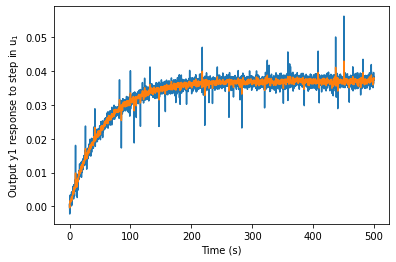

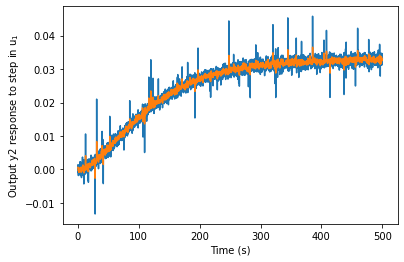

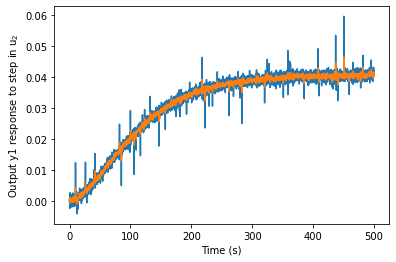

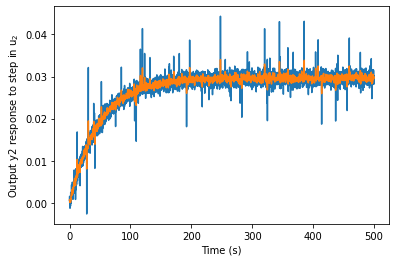

In [ ]:
#Plotting all the cleaned step responses (4 in total)
plt.figure()
plt.step(t_step, y1_u1nc)
plt.step(t_step, y1_u1)
plt.xlabel('Time (s)')
plt.ylabel('Output y1 response to step in u$_1$');


plt.figure()
plt.step(t_step, y2_u1nc)
plt.step(t_step, y2_u1)
plt.xlabel('Time (s)')
plt.ylabel('Output y2 response to step in u$_1$');


plt.figure()
plt.step(t_step, y1_u2nc)
plt.step(t_step, y1_u2)
plt.xlabel('Time (s)')
plt.ylabel('Output y1 response to step in u$_2$');


plt.figure()
plt.step(t_step, y2_u2nc)
plt.step(t_step, y2_u2)
plt.xlabel('Time (s)')
plt.ylabel('Output y2 response to step in u$_2$')

In [ ]:
# Dynamic matrix
# sf (Just for check and simpify the sf code)
Sf11 = np.zeros((P,M)) # initialization
Sf12 = np.zeros((P,M)) # initialization
Sf21 = np.zeros((P,M)) # initialization
Sf22 = np.zeros((P,M)) # initialization
for i in range(0,M):
  Sf11[i:,i] = y1_u1[1:P+1-i]
for i in range(0,M):
  Sf12[i:,i] = y1_u2[1:P+1-i]
for i in range(0,M):
  Sf21[i:,i] = y2_u1[1:P+1-i]
for i in range(0,M):
  Sf22[i:,i] = y2_u2[1:P+1-i]
Sf1 = np.column_stack((Sf11, Sf12))
Sf2 = np.column_stack((Sf21, Sf22))
Sf = np.vstack((Sf1, Sf2))
print(Sf11.shape)
print(Sf12.shape)
print(Sf1.shape)
print(Sf.shape)

# Spast (Just for check and simpify the Spast code)
Spast11 = np.zeros((P,N-2)) # initialization
Spast12 = np.zeros((P,N-2)) # initialization
Spast21 = np.zeros((P,N-2)) # initialization
Spast22 = np.zeros((P,N-2)) # initialization
for i in range(0,P):
  Spast11[i,0:N-2-i] = y1_u1[2+i:N]
for i in range(0,P):
  Spast12[i,0:N-2-i] = y1_u2[2+i:N]
for i in range(0,P):
  Spast21[i,0:N-2-i] = y2_u1[2+i:N]
for i in range(0,P):
  Spast22[i,0:N-2-i] = y2_u2[2+i:N]
Spast1 = np.column_stack((Spast11, Spast21))
Spast2 = np.column_stack((Spast12, Spast22))
Spast = np.vstack((Spast1,Spast2))
# print(Spast1.shape)
# print(Spast2.shape)
# print(Spast.shape)

# SN
SN11 = y1_u1[N]
SN12 = y1_u2[N]
SN21 = y2_u1[N]
SN22 = y2_u2[N]
SN11

(6, 5)
(6, 5)
(6, 10)
(12, 10)


0.037696197601619026

In [ ]:
# Initialize variables - generalize for the loop
u1 = np.ones((1,round(t_f/delta_t)+1)) * qa # initialize input vector
u2 = np.ones((1,round(t_f/delta_t)+1)) * qb # initialize input vector
x1 = np.ones((1,round(t_f/delta_t)+1)) * h1_0 # initialize state vector
x2 = np.ones((1,round(t_f/delta_t)+1)) * h2_0 # initialize state vector
x3 = np.ones((1,round(t_f/delta_t)+1)) * h3_0 # initialize state vector
x4 = np.ones((1,round(t_f/delta_t)+1)) * h4_0 # initialize state vector
x = np.vstack((x1,x2,x3,x4))
y1 = np.ones((1,round(t_f/delta_t)+1)) * h1_0 # initialize output vector
y2 = np.ones((1,round(t_f/delta_t)+1)) * h2_0 # initialize output vector

u1_past = np.ones(N-1) * qa  # initialize past inputs for DMC calculation
u2_past = np.ones(N-1) * qb  # initialize past inputs for DMC calculation

d_hat1 = np.zeros((P,round(t_f/delta_t)+1)) # initialize predicted disturbances
d_hat2 = np.zeros((P,round(t_f/delta_t)+1)) 
y1_hat = np.ones((1,round(t_f/delta_t)+1)) * h1_0 # initialize output vector
y2_hat = np.ones((1,round(t_f/delta_t)+1)) * h2_0 
error1 = np.zeros((1,round(t_f/delta_t)+1)) # initialize error
error2 = np.zeros((1,round(t_f/delta_t)+1))

In [ ]:
for k in range(0,round(t_f/delta_t),1):
  delta_u1_past = u1_past[0:N-2] - u1_past[1:N-1]
  delta_u2_past = u2_past[0:N-2] - u2_past[1:N-1]
  delta_u_past = np.hstack((delta_u1_past,delta_u2_past)).reshape(2*(N-2),1)

  u1_past_flip = np.flip(u1_past)
  u2_past_flip = np.flip(u2_past)
  u1_p = u1_past_flip[0:P].reshape(P,1) 
  u2_p = u2_past_flip[0:P].reshape(P,1) 

  E1 = r1-((Spast1@delta_u_past).reshape(P,1)+SN11*u1_p+SN12*u2_p+d_hat1[:,k].reshape(P,1))
  E2 = r2-((Spast2@delta_u_past).reshape(P,1)+SN21*u1_p+SN22*u2_p+d_hat2[:,k].reshape(P,1))

#   delta_u1_f = np.linalg.inv((Sf1.T@Sf1)+W)@Sf1.T@E1
#   delta_u2_f = np.linalg.inv((Sf2.T@Sf2)+W)@Sf2.T@E2


#WRITING THE CONSTRAINED MINIMIZATION CODE: 
  #Writing constraint equation
  a=np.ones(2*M)
  B=np.zeros((2*M,2*M))
  B[:,0]=a
  for i in range(2*M):
      B[:,i][i:2*M]=B[:,0][i:2*M]
  b=B*-1
  Aqp=np.vstack((B,b))


  #Hard limit of pump flowrate physical limitations
  umin=10.0
  umax=300
  del_u1max=50*np.ones((2*M,1))
  u1contop=(umin-u1[0,k-1])*np.ones((2*M,1))
  u1conbot=(u1[0,k-1]-umax)*np.ones((2*M,1))
  u2contop=(umin-u2[0,k-1])*np.ones((2*M,1)) 
  u2conbot=(u2[0,k-1]-umax)*np.ones((2*M,1))
  bqp1=np.vstack((u1contop,u1conbot))
  bqp2=np.vstack((u2contop,u2conbot))
    
 #Quadratic objective
  H1=Sf1.T@Sf1+W1
  ct1=E1.T@Sf1
  n1=cp.Variable((2*M,1))
  prob1=cp.Problem(cp.Minimize((1/2)*cp.quad_form(n1,H1) + -ct1@n1),[Aqp@n1>=bqp1,n1<=del_u1max])
  prob1.solve()
  delta_u1_f=n1.value

  H2=Sf2.T@Sf2+W2
  ct2=E2.T@Sf2
  n2=cp.Variable((2*M,1))
  del_u2max=50*np.ones((2*M,1))
  prob2=cp.Problem(cp.Minimize((1/2)*cp.quad_form(n2,H2) + -ct2@n2),[Aqp@n2>=bqp2,n2<=del_u2max])
  prob2.solve()
  delta_u2_f=n2.value

  if (k>0):
   u1[0,k] = delta_u1_f[0] + u1[0,k-1]
   u1[0,k+1] = u1[0,k]
  else:
    u1[0,k] = qa
  
  if (k>0):
   u2[0,k] = delta_u2_f[0] + u2[0,k-1]
   u2[0,k+1] = u2[0,k]
  else:
    u2[0,k] = qb
  u = np.vstack((u1,u2))

  # Plant equations taken as the real model
  x[:,k+1] = np.dot(Phi,x[:,k])+np.dot(Gamma,u[:,k])
  D1 = D[0,:].reshape(1,2)
  D2 = D[1,:].reshape(1,2)
  C1 = C[0,:].reshape(1,4)
  C2 = C[1,:].reshape(1,4)    
  y1[:,k+1] = np.dot(C1,x[:,k+1])+np.dot(D1,u[:,k+1])
  y2[:,k+1] = np.dot(C2,x[:,k+1])+np.dot(D2,u[:,k+1])

  #Step response model prediction for k+1
  y1_hat[:,k+1] = np.dot(Sf11[0,:],delta_u1_f[0:M])+np.dot(Sf12[0,:],delta_u2_f[0:M])+np.dot(Spast1[0,:],delta_u_past)+SN11*u1_p[0]+SN12*u2_p[0]
  y2_hat[:,k+1] = np.dot(Sf21[0,:],delta_u1_f[0:M])+np.dot(Sf22[0,:],delta_u2_f[0:M])+np.dot(Spast2[0,:],delta_u_past)+SN21*u1_p[0]+SN22*u2_p[0]

  #Calculation of disturbance correction
  d_hat1[:,k+1] = y1[0,k+1]-y1_hat[:,k+1]
  d_hat2[:,k+1] = y2[0,k+1]-y2_hat[:,k+1]

  u1_past = np.hstack((u1[0,k],u1_past[0:N-2]))
  u2_past = np.hstack((u2[0,k],u2_past[0:N-2]))

  error1[:,k+1] = r1[1,0]-y1[0,k+1]
  error2[:,k+1] = r2[1,0]-y2[0,k+1] 

9.494026387347084
7.246885984776252


(50.0, 350.0)

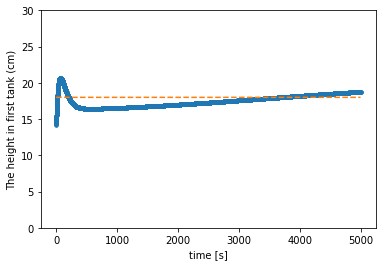

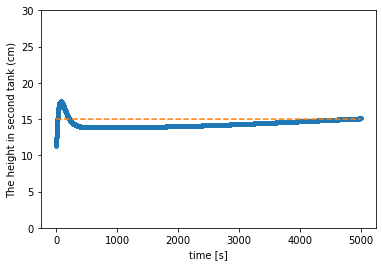

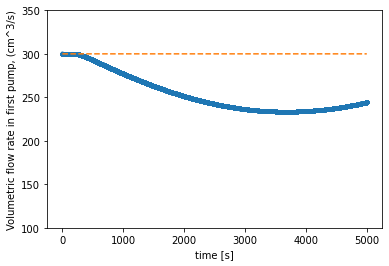

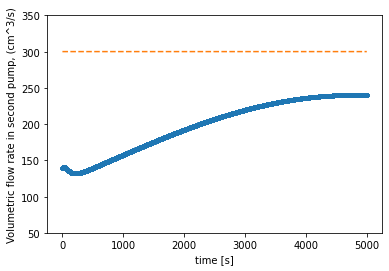

In [ ]:
t = np.linspace (0, t_f, round(t_f/delta_t)+1)
MSE1 = np.sum(np.square(error1)) / t_f
print(MSE1)
MSE2 = np.sum(np.square(error2)) / t_f
print(MSE2)
plt.figure()
plt.plot(t,y1[0],'.',label='output')
plt.plot(t,np.ones(len(t))*18, '--', label = 'Set Point') 
plt.xlabel('time [s]')
plt.ylabel('The height in first tank (cm)')
plt.ylim(0,30)

plt.figure()
plt.plot(t,y2[0],'.',label='output')
plt.plot(t,np.ones(len(t))*15, '--', label = 'Set Point') 
plt.xlabel('time [s]')
plt.ylabel('The height in second tank (cm)')
plt.ylim(0,30)

plt.figure()
plt.plot(t,u1[0],'.',label='input')
plt.xlabel('time [s]')
plt.plot(t,np.ones(len(t))*300, '--', label = 'Max pump flow') 
plt.ylabel('Volumetric flow rate in first pump, (cm^3/s)') 
plt.ylim(100,350)

plt.figure()
plt.plot(t,u2[0],'.',label='input')
plt.xlabel('time [s]')
plt.plot(t,np.ones(len(t))*300, '--', label = 'Max pump flow')
plt.ylabel('Volumetric flow rate in second pump, (cm^3/s)')
plt.ylim(50,350)